# CSE519 Data Science Fundamentals - HW3
* Huy Anh Nguyen
* SBID: 113094662
* Email: anh.h.nguyen@stonybrook.edu

## **Setup**

- Code to download the data directly from the colab notebook.
- If you find it easier to download the data from the kaggle website (and uploading it to your drive), you can skip this section.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# First mount your drive before running these cells. 
# Create a folder for the this HW and change to that dir
%cd drive/MyDrive/519_HW3

/content/drive/MyDrive/519_HW3


In [4]:
# !pip install --upgrade --force-reinstall --no-deps kaggle

In [4]:
# from google.colab import files
# # Create a new API token under "Account" in the kaggle webpage and download the json file
# # Upload the file by clicking on the browse 
# files.upload()

In [5]:
# !cp kaggle.json /root/.kaggle/

In [6]:
# !kaggle competitions download -c  rossmann-store-sales

In [7]:
# !unzip rossmann-store-sales.zip

## **Section 1: Library and Data Imports (Q1)**

- Import your libraries and read the data into a dataframe. Print the head of the dataframe. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
#fill in dtypes dict for efficient memory utilization
train_dtypes = {"Store": np.int32,
          "DayofWeek": np.int8,
          "Sales": np.int32, # turnover of a day
          "Customers": np.int32, # num of customers a day
          "Open": np.int8, # 0, 1
          "Promo": np.int8, # 0, 1
          "StateHoliday": "category", # 0, a, b, c
          "SchoolHoliday": np.int8,} # 0, 1

In [7]:
store_dtypes = {"Store": np.int32, # id of store
                "StoreType": "category", # a, b, c, d -> 4 models of stores
                "Assortment": "category", # a, b, c -> assortment levels
                "CompetitionDistance": np.float32, 
                "CompetitionOpenSinceMonth": np.float16,
                "CompetitionOpenSinceYear": np.float16,
                "Promo2": np.int8, # 0, 1 -> participating or not
                "Promo2SinceWeek": np.float16,
                "Promo2SinceYear": np.float16,
                "PromoInterval": "category" # months in year to start promo
                }

In [8]:
train_df = pd.read_csv('train.csv', dtype = train_dtypes, parse_dates=["Date"])
store_df = pd.read_csv("store.csv", dtype = store_dtypes)

In [9]:
data = pd.merge(train_df, store_df, how="inner", on=["Store", "Store"], left_index=True)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1114
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int32         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int32         
 4   Customers                  1017209 non-null  int32         
 5   Open                       1017209 non-null  int8          
 6   Promo                      1017209 non-null  int8          
 7   StateHoliday               1017209 non-null  category      
 8   SchoolHoliday              1017209 non-null  int8          
 9   StoreType                  1017209 non-null  category      
 10  Assortment                 1017209 non-null  category      
 11  CompetitionDistance        1014567 non-n

In [18]:
data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
0,1,4,2015-07-30,5020,546,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
0,1,3,2015-07-29,4782,523,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
0,1,2,2015-07-28,5011,560,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
0,1,1,2015-07-27,6102,612,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


## **Section 2: Effect of Holidays (Q2)**

**Initial observation**: There are two columns indicate the holidays
* StateHoliday: *almost* all stores are closed
    * a = public holiday -> all schools are closed
    * b = Easter holiday
    * c = Christmas

* SchoolHoliday:
    * 0 
    * 1 = Schools closed, it might affect store

And also Open -> store is closed or not

In [19]:
holidays = data.loc[(data["StateHoliday"] != "0") | (data["SchoolHoliday"] ==1)]["Date"].unique()
state_holidays = data[data["StateHoliday"] != "0"]["Date"].unique()
school_holidays = data[data["SchoolHoliday"] == 1]["Date"].unique()
overlap_holidays = data.loc[(data["StateHoliday"] != "0") & (data["SchoolHoliday"] ==1)]["Date"].unique()

In [20]:
data[data["StateHoliday"] == "c"]["Date"].value_counts()

2013-12-26    1115
2013-12-25    1115
2014-12-25     935
2014-12-26     935
Name: Date, dtype: int64

So, not all the stores have the same number of holidays.

### Christmas Holidays
We analyze the average sales (across all stores) during Dec 17 to Dec 31 each year.

In [21]:
# Christmas 2013
christmas_13 = []
avg_christmas_13 = []
for i in range(15):
    tmp = pd.Timestamp("2013-12-17") + pd.Timedelta(i,"D")
    christmas_13.append(data[data["Date"] == tmp]["Sales"].mean())
    avg_christmas_13.append(data[data["Date"] == tmp]["Customers"].mean())

# Christmas 2014
christmas_14 = []
for i in range(15):
    tmp = pd.Timestamp("2014-12-17") + pd.Timedelta(i,"D")
    christmas_14.append(data[data["Date"] == tmp]["Sales"].mean())

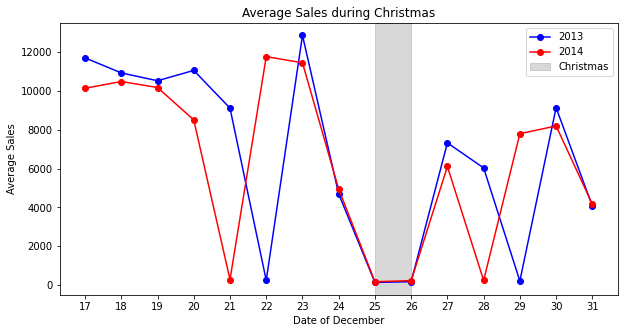

In [22]:
plt.figure(figsize=(10,5))
plt.plot(christmas_13, "o-", c="blue", label="2013")
plt.plot(christmas_14, "o-", c="red", label="2014")
plt.axvspan(8, 9, color="gray", alpha=0.3, label="Christmas")
plt.xticks([i for i in range(15)], labels = [str(i) for i in range(17,32)])
plt.xlabel("Date of December")
plt.ylabel("Average Sales")
plt.title("Average Sales during Christmas")
plt.legend()
plt.show()

* So in the plot, we can see the sales went up sharply 2 days before Christmas. During the holidays, the sales is very low. And it went up again 1 day after the Christmas (Dec 26)
* I noticed that on Dec 21 and Dec 28 of 2013 (exactly 1 week) and Dec 22 and Dec 29 of 2014, there is something happened that very few stores opened on these days. So the sales were as low as during Christmas.

### Easter Days

In [23]:
# Easter day
data[data["StateHoliday"] == "b"]["Date"].value_counts()

2013-03-29    1115
2014-04-18    1115
2013-04-01    1115
2015-04-03    1115
2014-04-21    1115
2015-04-06    1115
Name: Date, dtype: int64

Interesting that each year there were two Easter Days and both are holidays for all stores. After doing some research, they are Orthodox Easter and Catholic Easter. Lucklily, they were exactly 4 days apart so I just create a window of 10 days, 3 days before the first Easter Day, 4 days between these two days and 3 days after the second Easter day to see how the sales were going.

In [24]:
easter_13 = []
for i in range(10):
    tmp = pd.Timestamp("2013-03-26") + pd.Timedelta(i,"D")
    easter_13.append(data[data["Date"] == tmp]["Sales"].mean())

easter_14 = []
for i in range(10):
    tmp = pd.Timestamp("2014-04-15") + pd.Timedelta(i,"D")
    easter_14.append(data[data["Date"] == tmp]["Sales"].mean())

easter_15 = []
for i in range(10):
    tmp = pd.Timestamp("2015-03-31") + pd.Timedelta(i,"D")
    easter_15.append(data[data["Date"] == tmp]["Sales"].mean())

[]

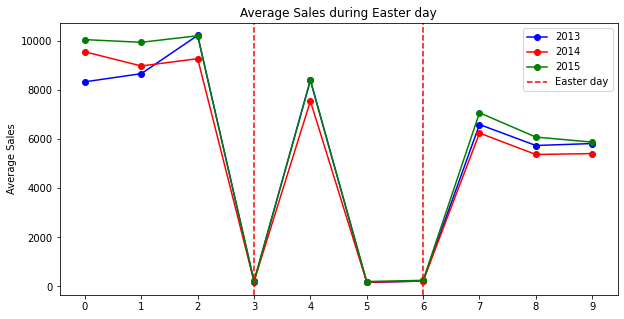

In [25]:
plt.figure(figsize=(10,5))
plt.plot(easter_13, "o-", c="blue", label="2013")
plt.plot(easter_14, "o-", c="red", label="2014")
plt.plot(easter_15, "o-", c="green", label="2015")
plt.xticks(np.arange(10))
plt.axvline(3, c="r", ls="--", label="Easter day")
plt.axvline(6, c="r", ls="--")
plt.ylabel("Average Sales")
plt.title("Average Sales during Easter day")
plt.legend()
plt.plot()

* Easter days have pretty the same pattern as Christmas, where the sales went up before the holidays, being low during the holidays and increased again 1 day before that.
* One thing to notice that the low sale on 5th day, just 1 day before the second Easter Day. I dont know if normally people celebrate both two days or just one day, but I think that 1 day after the first Easter day, people who needs medicine went to buy them so the need is low in the next day, right before the second Easter day.

### Public Holidays

First let's take a look at the Public Holidays and determine the window size to scan.

In [26]:
store_id = store_df["Store"]
tmp = data[data["StateHoliday"] == "a"]["Date"].value_counts().sort_index()

In [27]:
tmp = data.loc[(data["Date"] == pd.Timestamp("2014-11-19")) & (data["StateHoliday"] == "a")]["Store"].unique()

In [28]:
data.loc[(data["Store"].isin(tmp)) & (data["Date"] == pd.Timestamp("2014-11-18"))]["Sales"].sum()

480757

In [29]:
holidays = data[data["StateHoliday"] == "a"]["Date"].value_counts().index
total_sale = [0, 0, 0]
total_stores = [0, 0, 0]
for day in holidays:
    store_id = data.loc[(data["Date"] == pd.Timestamp(day)) & (data["StateHoliday"] == "a")]["Store"].unique()
    # 1 day before
    yesterday = day - pd.Timedelta(1, "D")
    tmp = data.loc[(data["Store"].isin(store_id)) & (data["Date"] == yesterday)]["Sales"]
    total_sale[0] += tmp.sum()
    total_stores[0] += tmp.count()

    # On that day
    tmp = data.loc[(data["Store"].isin(store_id)) & (data["Date"] == day)]["Sales"]
    total_sale[1] += tmp.sum()
    total_stores[1] += tmp.count()

    # 1 day after
    tomorrow = day + pd.Timedelta(1, "D")
    tmp = data.loc[(data["Store"].isin(store_id)) & (data["Date"] == tomorrow)]["Sales"]
    total_sale[2] += tmp.sum()
    total_stores[2] += tmp.count()

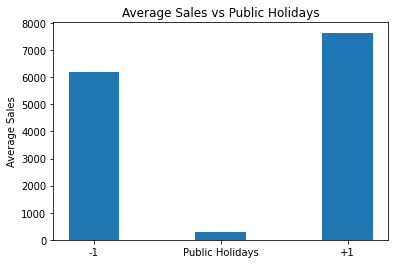

In [30]:
#plt.figure(figsize=(4,6))
average_sales = [total_sale[i]/total_stores[i] for i in range(3)]
xlabels = ["-1", "Public Holidays", "+1"]
plt.bar(xlabels, average_sales, width = 0.4)
plt.ylabel("Average Sales")
plt.title("Average Sales vs Public Holidays")
plt.show()

So one day before and one day after a public holidays, the sale went up sharply. It matched the pattern in Easter days and Christmas

In [31]:
data[data["SchoolHoliday"] == 1]["Date"].value_counts().sort_index()

2013-01-01    1114
2013-01-02    1115
2013-01-03    1040
2013-01-04    1040
2013-01-05     112
              ... 
2015-07-27     862
2015-07-28     862
2015-07-29     862
2015-07-30     935
2015-07-31     935
Name: Date, Length: 478, dtype: int64

In [32]:
total_sales = [0, 0, 0]
total_entries = [0, 0, 0]
for id in tqdm(store_id):
    school_holidays = data.loc[(data["Store"] == id) & (data["SchoolHoliday"] == 1)]["Date"]
    for day in school_holidays:
        # Handle consecutive holidays
        yesterday = day - pd.Timedelta(1, "D")
        if yesterday not in school_holidays:
            total_sales[0] += data.loc[(data["Store"] == id) & (data["Date"] == yesterday)]["Sales"]
            total_entries[0] += 1

        tomorrow = day + pd.Timedelta(1, "D")
        if tomorrow not in school_holidays:
            total_sales[2] += data.loc[(data["Store"] == id) & (data["Date"] == tomorrow)]["Sales"]
            total_entries[2] += 1   

        total_sales[1] += data.loc[(data["Store"] == id) & (data["Date"] == day)]["Sales"]
        total_entries[1] += 1

100%|██████████| 75/75 [03:55<00:00,  3.14s/it]


In [31]:
average_sales = [total_sale[i]/total_entries[i] for i in range(3)]
total_entries

[12900, 12900, 12900]

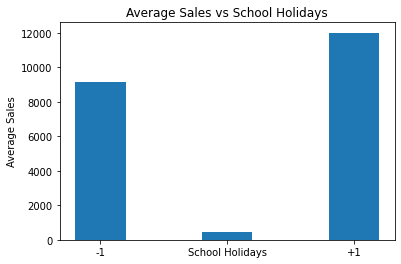

In [32]:
xlabels = ["-1", "School Holidays", "+1"]
plt.bar(xlabels, average_sales, width = 0.4)
plt.ylabel("Average Sales")
plt.title("Average Sales vs School Holidays")
plt.show()

We have the same phenomena in School Holidays.

**Conclusion**: Holidays in general affects the average sales badly where store average sales decreased by a big margin. But right before and after holidays, the sales went up as people prepare before the stores close.

## **Section 3: Most and Least selling stores (Q3a & Q3b)**

### Q3a

In [62]:
# 6 months requirements
(data.groupby(["Store"])["Date"].max() - data.groupby(["Store"])["Date"].min()).min()

Timedelta('940 days 00:00:00')

All stores have been operating for more than 6 months. So we don't have to care about the condition anymore.

In [63]:
print("The 5 stores with the highest cummulative sales:")
highest = data.groupby(["Store"])["Sales"].sum().sort_values()[:5]
for store, value in highest.iteritems():
    print("Store", store, "with cummulative sales:", value)
highest_id = highest.index.to_numpy()

The 5 stores with the highest cummulative sales:
Store 307 with cummulative sales: 2114322
Store 543 with cummulative sales: 2179287
Store 198 with cummulative sales: 2268273
Store 208 with cummulative sales: 2302052
Store 263 with cummulative sales: 2306075


In [64]:
print("The 5 stores with the lowest cummulative sales:")
lowest = data.groupby(["Store"])["Sales"].sum().sort_values()[-5:]
for store, value in lowest.iteritems():
    print("Store", store, "with cummulative sales:", value)
lowest_id = lowest.index.to_numpy()

The 5 stores with the lowest cummulative sales:
Store 251 with cummulative sales: 14896870
Store 1114 with cummulative sales: 16202585
Store 562 with cummulative sales: 16927322
Store 817 with cummulative sales: 17057867
Store 262 with cummulative sales: 19516842


In [65]:
q3_df = data[data["Store"].isin(np.hstack([highest_id, lowest_id]))][["Store", "Date", "Sales"]]

In [66]:
# Extract Week of Year and Year from DateTime
# Notice that extract year and week independently 
# could cause an issue as follow
print(pd.Timestamp.isocalendar(pd.Timestamp("2021-1-1")))
print(pd.Timestamp("2021-1-1").year, pd.Timestamp("2021-1-1").week)

(2020, 53, 5)
2021 53


In [67]:
# Convert DateTime to ISO 8601 Year and Week of Year
q3_df["Year"] = q3_df["Date"].map(lambda x: pd.Timestamp.isocalendar(x)[0])
q3_df["Week"] = q3_df["Date"].map(lambda x: pd.Timestamp.isocalendar(x)[1])
q3_df.head()

,Store,Date,Sales,Year,Week
197,198,2015-07-31,3824,2015,31
197,198,2015-07-30,3211,2015,31
197,198,2015-07-29,2986,2015,31
197,198,2015-07-28,4597,2015,31
197,198,2015-07-27,4906,2015,31


In [68]:
q3_df["Year"].value_counts()

2013    3630
2014    3459
2015    2147
Name: Year, dtype: int64

In [69]:
# It's still little messy with both Year and Week, so I'm gonna combine them
# We only have data from 2013 to 2015
print(q3_df["Year"].min(), q3_df["Year"].max())

2013 2015


In [70]:
# As in ISO 8601, last week always has Dec 28 in it
print(pd.Timestamp.isocalendar(pd.Timestamp("2013-12-28")))
print(pd.Timestamp.isocalendar(pd.Timestamp("2014-12-28")))
print(pd.Timestamp.isocalendar(pd.Timestamp("2015-12-28")))
# 2013 has 52 weeks -> stay intact
# 2014 has 52 weeks -> add 52 to all week in 2014
# 2015 has 53 weeks -> add 52 + 52 = 104 to all week in 2015

(2013, 52, 6)
(2014, 52, 7)
(2015, 53, 1)


In [71]:
q3_df.loc[q3_df["Year"] == 2014, "Week"] += 52
q3_df.loc[q3_df["Year"] == 2015, "Week"] += 104

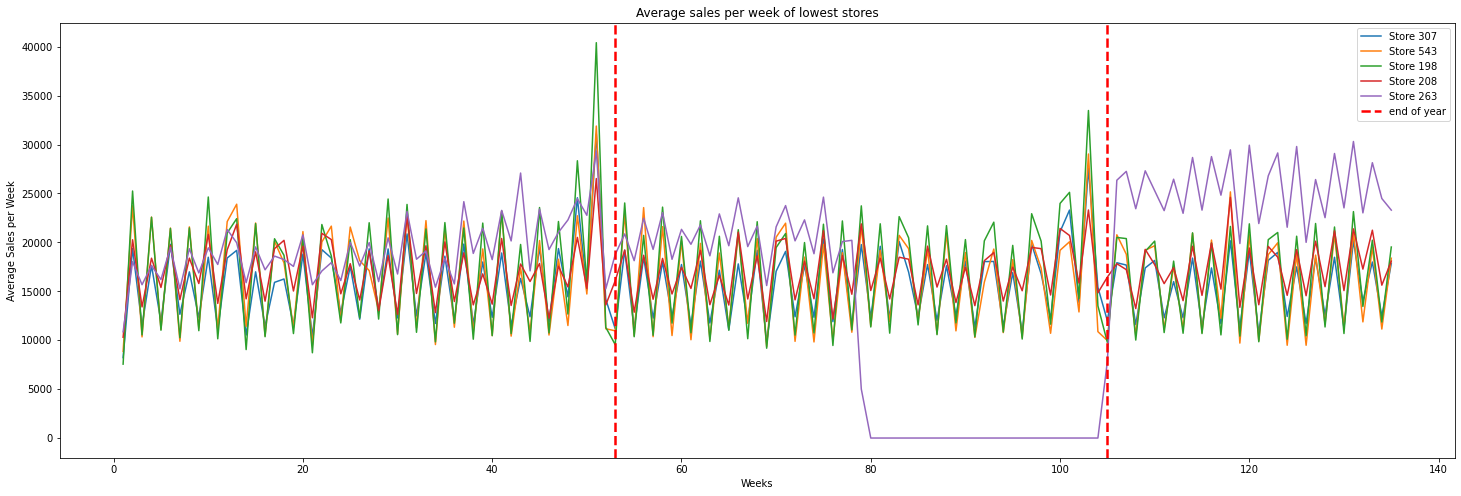

In [134]:
# Plotting time
num_weeks = 135
plt.figure(figsize=(25, 8))
series_a = []
for id in highest_id:
    tmp = q3_df[q3_df["Store"]==id].groupby("Week")["Sales"].sum()

    label = "Store {}".format(id)
    if len(tmp.index) != num_weeks:
        for week in range(1, num_weeks):
            if week not in tmp.index:
                tmp[week] = 0
        tmp = tmp.sort_index()
    tmp = tmp.rename(label)
    series_a.append(tmp)
    plt.plot(tmp.index, tmp.to_numpy(), label=label)

plt.axvline(x=53, color = "r", ls="--", linewidth = 2.5, label="end of year")
plt.axvline(x=105, color = "r", ls="--", linewidth = 2.5)
plt.ylabel("Average Sales per Week")
plt.xlabel("Weeks")
plt.title("Average sales per week of lowest stores")
plt.legend()
plt.show()

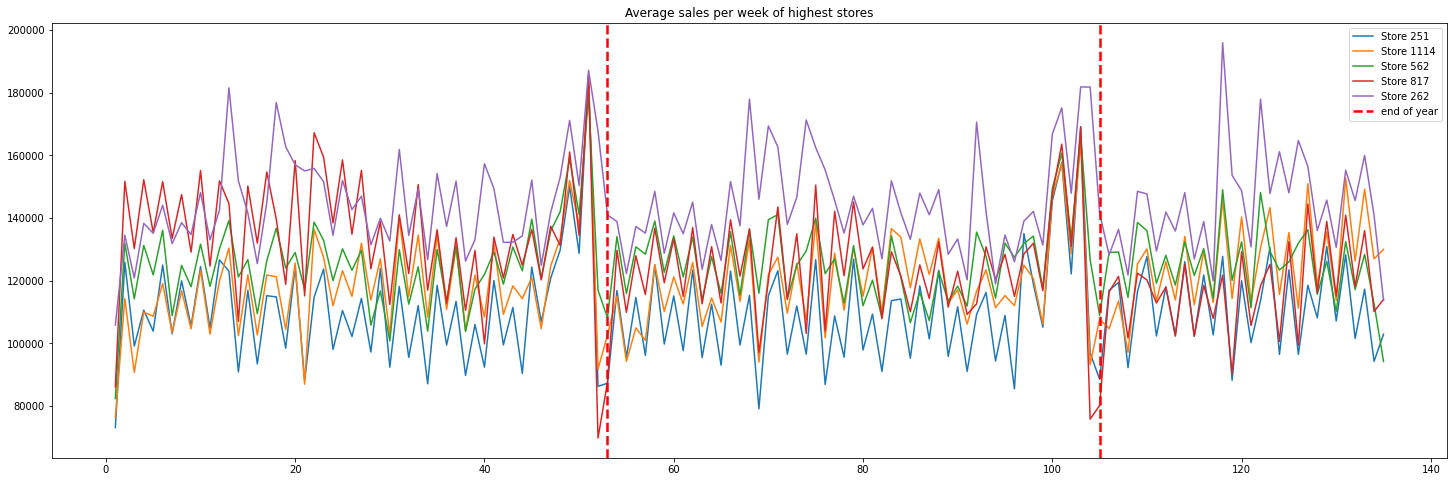

In [135]:
# Plotting time
plt.figure(figsize=(25, 8))
series_b = []
for id in lowest_id:
    tmp = q3_df[q3_df["Store"]==id].groupby("Week")["Sales"].sum()
    label = "Store {}".format(id)
    tmp = tmp.rename(label)
    series_b.append(tmp)
    plt.plot(tmp.index, tmp.to_numpy(), label=label)
plt.axvline(x=53, color = "r", ls="--", linewidth = 2.5, label="end of year")
plt.axvline(x=105, color = "r", ls="--", linewidth = 2.5)
plt.title("Average sales per week of highest stores")
plt.legend()
plt.show()

### Q3b

Pearson Correlation of Lowest Sales Stores

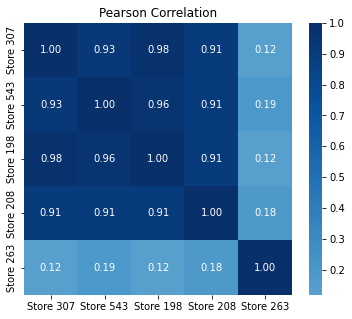

In [106]:
plt.figure(figsize = (6,5))
ax = sns.heatmap(pd.DataFrame(series_a).T.corr('pearson'), center=0, annot=True, fmt=".2f", cmap="Blues").set_title("Pearson Correlation")

So 4/5 of stores have very high correlation. The last one (Store 263) only had 110 days of opening (compared to 155 of others) so it maybe the reason for significantly lower correlation. 

Pearson Correlation of Highest Sales Stores

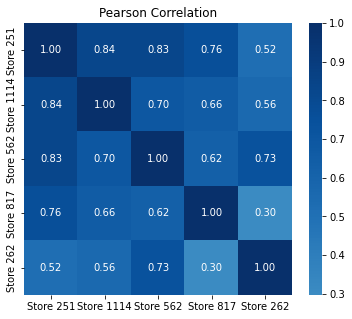

In [107]:
plt.figure(figsize = (6,5))
ax = sns.heatmap(pd.DataFrame(series_b).T.corr('pearson'), center=0, annot=True, fmt=".2f", cmap="Blues").set_title("Pearson Correlation")

These stores have pretty high correlation.

So now, I gonna compare two set together. From the two plots above, we can see that it have the similar spikes, especially in the end of each year. So maybe it has high correlation.

In [128]:
# Taking the mean of each set.
sales_per_week_a = pd.concat(series_a, axis=1).mean(axis=1)
sales_per_week_b = pd.concat(series_b, axis=1).mean(axis=1)

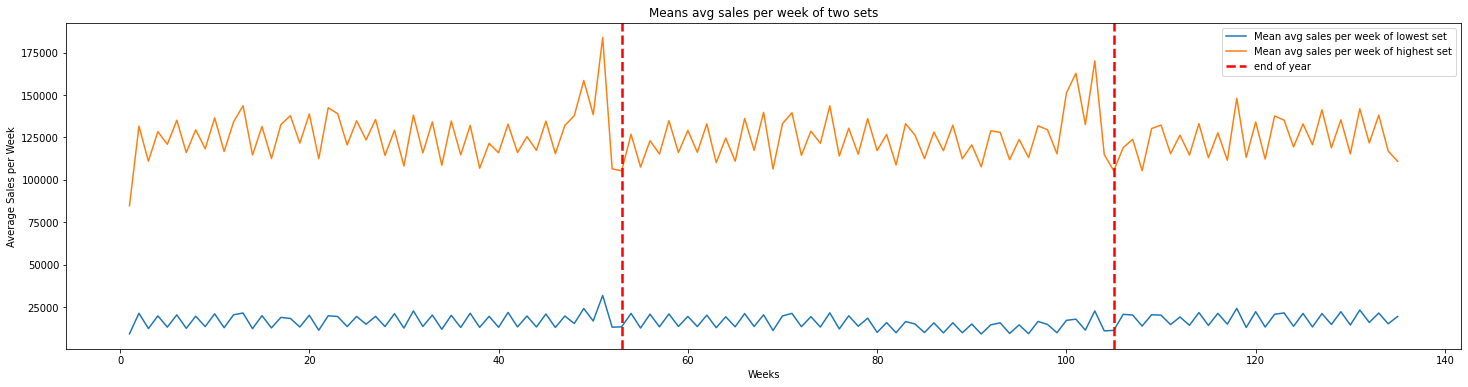

In [133]:
plt.figure(figsize=(25, 6))
plt.plot(sales_per_week_a, label="Mean avg sales per week of lowest set")
plt.plot(sales_per_week_b, label="Mean avg sales per week of highest set")
plt.axvline(x=53, color = "r", ls="--", linewidth = 2.5, label="end of year")
plt.axvline(x=105, color = "r", ls="--", linewidth = 2.5)
plt.ylabel("Average Sales per Week")
plt.xlabel("Weeks")
plt.title("Means avg sales per week of two sets")
plt.legend()
plt.show()

In [130]:
pd.concat([sales_per_week_a, sales_per_week_b], axis=1).corr()

,0,1
0,1.000000,0.808277
1,0.808277,1.000000


So, from both plot and correlation (0.81), we clearly see that both set have high correlation to each other.

In [47]:
del q3_df

## **Section 4: Closest Competitor: Distance and Age (Q4a & Q4b)**

Prepare the sales per week per store data. The technique is exactly the same as Q3.

In [48]:
q4_df = train_df[["Store", "Date", "Sales"]].copy()
q4_df["Year"] = q4_df["Date"].map(lambda x: pd.Timestamp.isocalendar(x)[0])
q4_df["Week"] = q4_df["Date"].map(lambda x: pd.Timestamp.isocalendar(x)[1])

In [49]:
q4_df.loc[q4_df["Year"] == 2014, "Week"] += 52
q4_df.loc[q4_df["Year"] == 2015, "Week"] += 104

In [50]:
cum_sales = q4_df.groupby(["Store"]).sum()["Sales"] 
num_weeks = q4_df.groupby(["Store"])["Week"].nunique()

In [51]:
sales_per_week = cum_sales/num_weeks
sales_per_week = sales_per_week.to_frame().reset_index()
sales_per_week = sales_per_week.rename(columns={0: "Sales_per_week"})

### Sales per week vs distance of the closest competitor

In [52]:
sales_vs_distance = pd.merge(sales_per_week, store_df[["Store", "CompetitionDistance"]], how="inner", on=["Store", "Store"])
sales_vs_distance = sales_vs_distance.dropna()
sales_vs_distance["LogDistance"] = np.log(sales_vs_distance["CompetitionDistance"])

In [53]:
bins = [(i/2, i/2+0.5) for i in range(4, 24)][1:-1]

bins_center = [(bin[0]+bin[1])/2 for bin in bins]
def assign_bin(data, bins=bins):
    for i, bin in enumerate(bins):
        if data >= bin[0] and data < bin[1]:
            return i
    return -1

In [54]:
sales_vs_distance["Bins"] = sales_vs_distance["LogDistance"].apply(assign_bin)

In [55]:
mean_sales = sales_vs_distance.groupby(["Bins"])["Sales_per_week"].mean()
ci_sales = 3*sales_vs_distance.groupby(["Bins"])["Sales_per_week"].std()

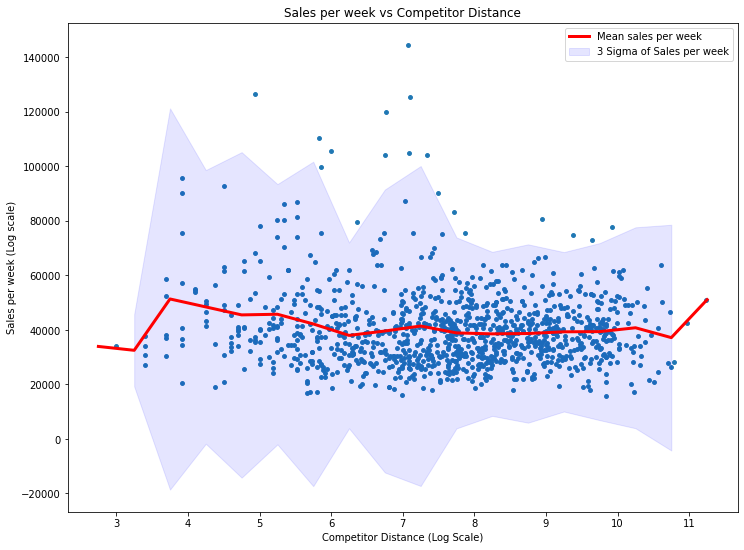

In [56]:
plt.figure(figsize=(12,9))
#plt.scatter(np.log(sales_vs_distance["CompetitionDistance"]), np.log(sales_vs_distance["Sales_per_week"]), s = 15)
plt.scatter(sales_vs_distance["LogDistance"], sales_vs_distance["Sales_per_week"], s = 15)
plt.plot(bins_center, mean_sales, c="r", linewidth=3, label="Mean sales per week")
plt.fill_between(bins_center, mean_sales - ci_sales, mean_sales + ci_sales, color='b', alpha=.1, label="3 Sigma of Sales per week")
plt.title("Sales per week vs Competitor Distance")
plt.xlabel("Competitor Distance (Log Scale)")
plt.xticks(np.arange(3,12))
plt.ylabel("Sales per week (Log scale)")
plt.legend()
plt.show()

**Conclusion**: From the graph above, we clearly see that the mean average sales per week across stores is pretty much the same regardless the distance to competitors. It contracdicts with my initial thoughts but there are more in deep investigations in Q7.

## **Section 5: Pearson Correlation of Features (Q5)**

In [57]:
five_most_features = ["Sales", 
                     "Customers", 
                     "Promo",
                     "StateHoliday", 
                     "SchoolHoliday", 
                     "CompetitionDistance",
                    ]

In [58]:
q5_df = data[five_most_features].copy()

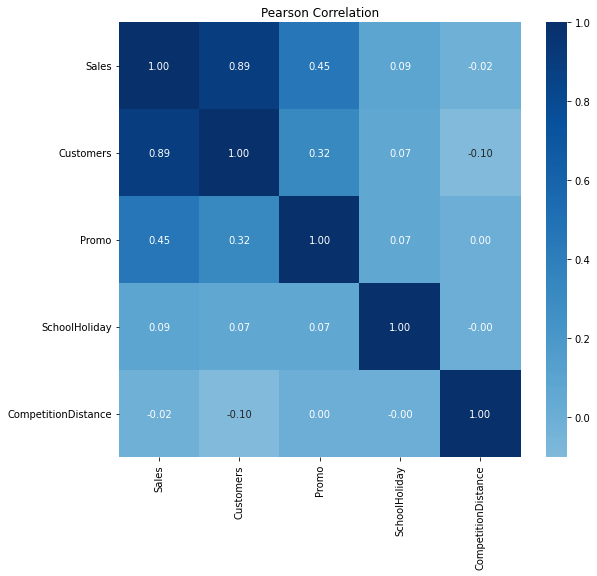

In [59]:
plt.figure(figsize = (9,8))
ax = sns.heatmap(q5_df.corr('pearson'), center=0, annot=True, fmt=".2f", cmap="Blues").set_title("Pearson Correlation")

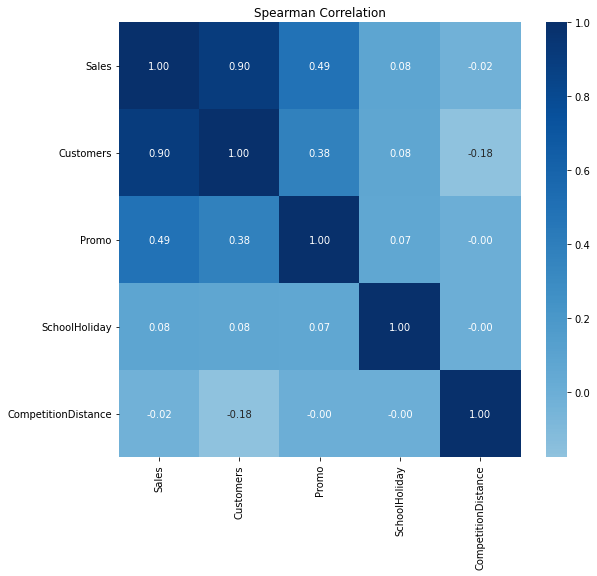

In [60]:
plt.figure(figsize = (9,8))
ax = sns.heatmap(q5_df.corr('spearman'), center=0, annot=True, fmt=".2f", cmap="Blues").set_title("Spearman Correlation")

**Conclusion**: 
* The feature-pairs with the strongest correlations: Sales and Customers.

* Customers correlates the best with Sales
* The Spearman correlation has the same result with the Pearson correlation. Although the values had changed a bit, but the order is the same.


## **Section 6: Permutation Testing (Q6)**

In [50]:
variables = ["Sales",
             "Customers", # Good
             "CompetitionDistance", # Meaningless
             "Promo", # Random
             ]
q6_df = data[variables].copy()
q6_df["LogSales"] = np.log1p(q6_df["Sales"]) 
y = q6_df["LogSales"].to_numpy()

In [51]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import permutation_test_score
# from sklearn.model_selection import StratifiedKFold

lin_reg = LinearRegression()

### Permutation test with Customers

In [52]:
X = q6_df["Customers"].to_numpy().reshape(-1,1)
score, perm_score, pvalue = permutation_test_score(lin_reg, X, y, scoring="neg_root_mean_squared_error", n_permutations=200)

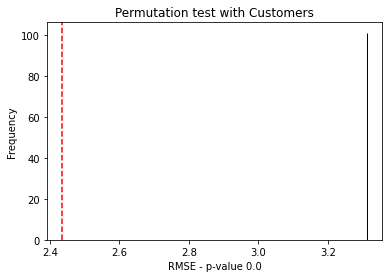

In [53]:
plt.hist(-1*perm_score, edgecolor="black")
plt.axvline(-1*score, ls="--", color="r")
plt.ylabel("Frequency")
plt.xlabel("RMSE - p-value {}".format(np.around(pvalue, 2)))
plt.title("Permutation test with Customers")
plt.show()

Note: I'm sorry the plot is so ugly but I don't know how to config the scale. So I plot the histogram below.

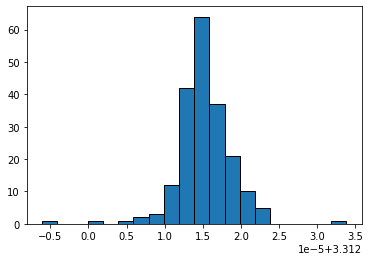

In [259]:
plt.hist(-1*perm_score, bins=20, edgecolor="black")
plt.show()

### Permutation test with CompetitionDistance

In [54]:
X = q6_df["CompetitionDistance"].dropna(0).to_numpy().reshape(-1,1)
score_2, perm_score_2, pvalue_2 = permutation_test_score(lin_reg, X, y, 
                                                         scoring="neg_root_mean_squared_error", 
                                                         n_permutations=200)

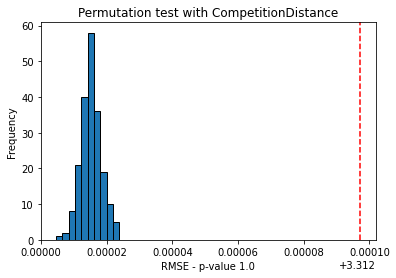

In [55]:
plt.hist(-1*perm_score_2, edgecolor="black")
plt.axvline(-1*score_2, ls="--", color="r")
plt.ylabel("Frequency")
plt.xlabel("RMSE - p-value {}".format(np.around(pvalue_2, 2)))
plt.title("Permutation test with CompetitionDistance")
plt.show()

### Permutations test with Promo

In [56]:
X = q6_df["Promo"].to_numpy().reshape(-1,1)
score_3, perm_score_3, pvalue_3 = permutation_test_score(lin_reg, X, y, scoring="neg_root_mean_squared_error", n_permutations=200)

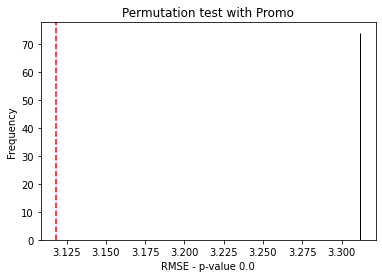

In [57]:
plt.hist(-1*perm_score_3, edgecolor="black")
plt.axvline(-1*score_3, ls="--", color="r")
plt.ylabel("Frequency")
plt.xlabel("RMSE - p-value {}".format(np.around(pvalue_3, 2)))
plt.title("Permutation test with Promo")
plt.show()

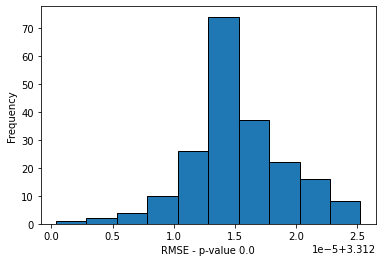

In [58]:
plt.hist(-1*perm_score_3, edgecolor="black")
plt.ylabel("Frequency")
plt.xlabel("RMSE - p-value {}".format(np.around(pvalue_3, 2)))
plt.show()

**Conclusion**: 
* For 200 permutations, we threshold the p-value to 0.005. That means with Promo and Customers, where their pvalue is close to 0, the null hypothesis that there is no relationship between log(sales) and variable is rejected. So between log(sales) and promo/customers have a relationship.

* For CompetitionDistance, since the p-value is 1 and the investigation I made in Q4 that Average Sales stays consistent across the range of distance, it's safe to say that we accept the null hypothesis.

In [59]:
del q6_df

## **Section 7: Interesting findings (Q7)**

### 1) Impact of new competitors establishment

In [61]:
q4b_df = data[["Store", "Sales", "Date", "Customers", "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear"]].copy()
q4b_df = q4b_df.dropna()
q4b_df["CompetitionTime"] = q4b_df["CompetitionOpenSinceYear"].astype(np.int16).astype(str) + "-" + q4b_df["CompetitionOpenSinceMonth"].astype(np.int16).astype(str)
q4b_df["CompetitionTime"] = q4b_df["CompetitionTime"].map(lambda x: pd.Timestamp(x))
q4b_df["DiffWeek"] = (q4b_df["Date"] - q4b_df["CompetitionTime"])//np.timedelta64(1,'W')

But considering all the stores regardless its competitors opened within the time span of data (2013-1-1 to 2017) is some what misleading. So I filtered only stores that the time its competitors is within the data timespan.

These stores stores that have DiffWeek < 0

No handles with labels found to put in legend.


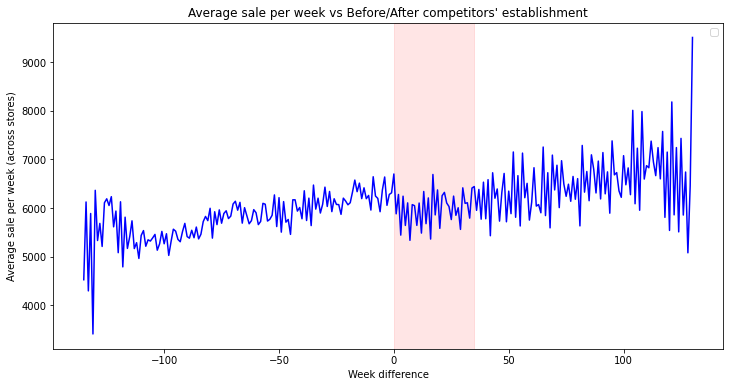

In [62]:
store_id = q4b_df[q4b_df["DiffWeek"] < 0]["Store"].unique()
tmp = q4b_df[q4b_df["Store"].isin(store_id)].groupby("DiffWeek").mean()
plt.figure(figsize=(12,6))
plt.plot(tmp.index, tmp["Sales"], color="b")
plt.axvspan(0, 35, color='r', alpha=.1)
# plt.axvline(x=0)
# plt.axvline(x=15)
plt.xlabel("Week difference")
plt.ylabel("Average sale per week (across stores)")
plt.title("Average sale per week vs Before/After competitors' establishment")
plt.show()

The graph shows that after a new competitor emerged, the sales went down for around 35 weeks (marked as red region). So the competitor establishment really affects the sales of a store.

In [63]:
del q4b_df, tmp, store_id

### 2) Competitor Distance vs Sales per Customer

In [64]:
q5_df = train_df[["Store", "Date", "Sales", "Customers"]].copy()

In [65]:
cum_sales = q5_df.groupby(["Store"]).sum()["Sales"]
cum_customers = q5_df.groupby(["Store"]).sum()["Customers"]
sale_per_cus = (cum_sales/cum_customers).to_frame()

In [66]:
tmp = pd.merge(sale_per_cus, store_df[["Store", "CompetitionDistance"]], how="inner", on=["Store", "Store"])
tmp = tmp.dropna()

In [67]:
tmp["LogDistance"] = np.log(tmp["CompetitionDistance"])
tmp["Bins"] = tmp["LogDistance"].apply(assign_bin)
mean_sales_per_cus = tmp.groupby(["Bins"])[0].mean()
ci_sales_per_cus = 3*tmp.groupby(["Bins"])[0].std()

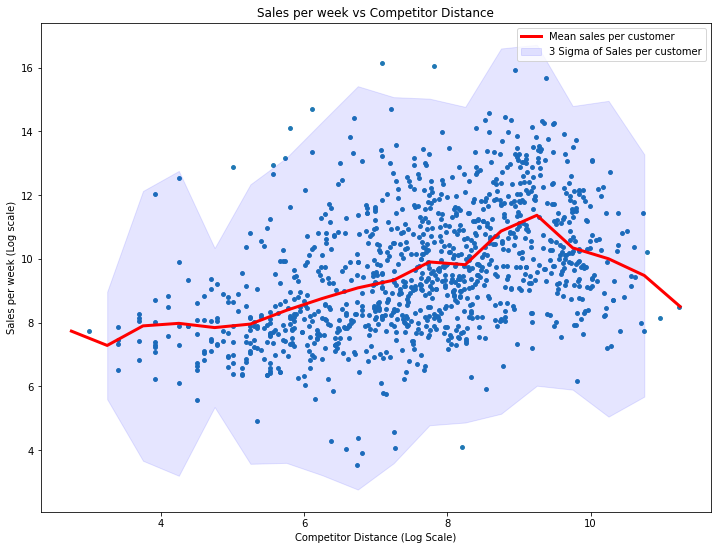

In [68]:
plt.figure(figsize=(12,9))
#plt.scatter(np.log(sales_vs_distance["CompetitionDistance"]), np.log(sales_vs_distance["Sales_per_week"]), s = 15)
plt.scatter(np.log(tmp["CompetitionDistance"]), tmp[0], s = 15)

plt.plot(bins_center, mean_sales_per_cus, c="r", linewidth=3, label="Mean sales per customer")
plt.fill_between(bins_center, mean_sales_per_cus - ci_sales_per_cus, mean_sales_per_cus + ci_sales_per_cus, color='b', alpha=.1, label="3 Sigma of Sales per customer")

plt.title("Sales per week vs Competitor Distance")
plt.xlabel("Competitor Distance (Log Scale)")
plt.ylabel("Sales per week (Log scale)")
plt.legend()
plt.show()

In Q4, I concluded that distance has no effect on sales per week. But let's consider another factor, sales per customer. A store that far away its competitor could mean that it locates in a small town, so the number of customers is small. But the graph reveals that the sales per customer is actually larger than the ones with close competitors. 

### 2) Analyst each Store types

In [75]:
customer_df = data[["Store", "Sales", "Customers", "StoreType", "Assortment"]].copy()

In [70]:
tmp = customer_df.groupby(["StoreType"]).sum()

In [71]:
store_type = ["a", "b", "c", "d"]
sales_per_customer = (tmp["Sales"]/tmp["Customers"]).to_numpy()
total_sales = tmp["Sales"].to_numpy()
num_stores = customer_df['StoreType'].value_counts(sort=False).to_numpy()
sales_per_store = total_sales/num_stores

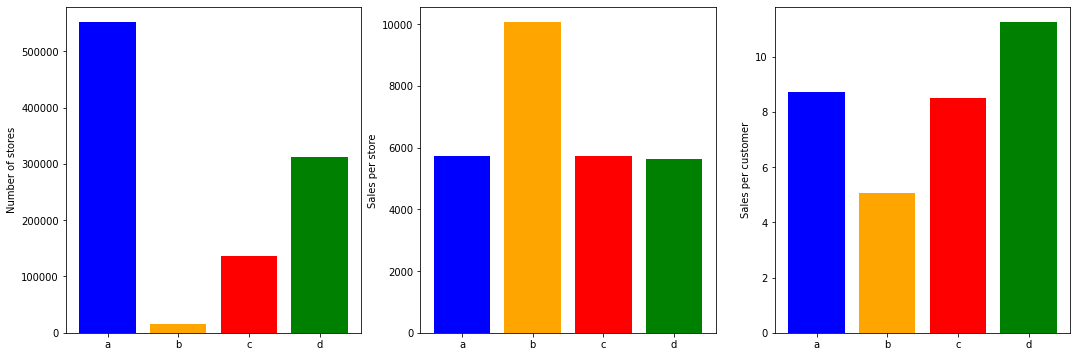

In [72]:
colors = ["blue", "orange", "red", "green"]
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].bar(store_type, num_stores, color=colors)
ax[0].set(ylabel="Number of stores")
ax[1].bar(store_type, sales_per_store, color=colors)
ax[1].set(ylabel="Sales per store")
ax[2].bar(store_type, sales_per_customer, color=colors)
ax[2].set(ylabel="Sales per customer")
plt.show()

The store type b has the smallest number of stores but it generates the largest sales per store and not much less sales per customers against the other types. So store b could be a large store located in big cities. Where the type a should be a branch/town store justified by its large number of stores. 

In [73]:
del tmp, sales_per_customer, total_sales, num_stores, sales_per_store, colors

### 3) Analyst each Store assortment

In [76]:
assortment_type = ["basic", "extra", "extended"]
tmp = customer_df.groupby(["Assortment"]).sum()

In [77]:
sales_per_customer = (tmp["Sales"]/tmp["Customers"]).to_numpy()
total_sales = tmp["Sales"].to_numpy()
num_stores = customer_df['Assortment'].value_counts(sort=False).to_numpy()
sales_per_store = total_sales/num_stores

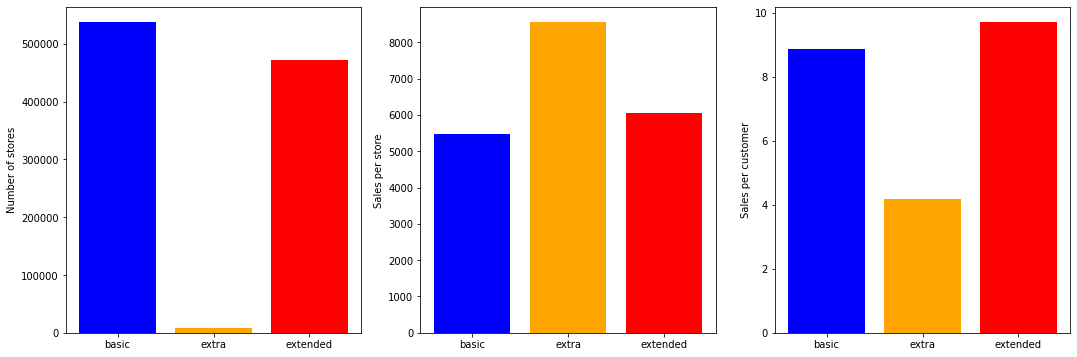

In [78]:
colors = ["blue", "orange", "red"]
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].bar(assortment_type, num_stores, color=colors)
ax[0].set(ylabel="Number of stores")
ax[1].bar(assortment_type, sales_per_store, color=colors)
ax[1].set(ylabel="Sales per store")
ax[2].bar(assortment_type, sales_per_customer, color=colors)
ax[2].set(ylabel="Sales per customer")
plt.show()

The extra store could be a luxury or very big ones because of its large sales per store while the number of its is very small. The sale per customers is not that large indicates that many customers just goes and checks the products but not buy anything. The extended, by it names, maybe have wide range of products so their sale per customers is large.

## 5) Analyst average sales and customers on different months and week days

In [79]:
tmp = train_df[train_df["Open"]==1].copy()
sales_per_days = tmp.groupby("DayOfWeek")["Sales"].mean()
customers_per_days = tmp.groupby("DayOfWeek")["Customers"].mean()

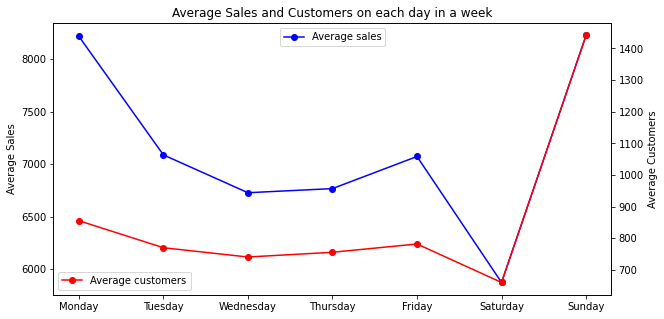

In [80]:
fig, ax1 = plt.subplots(figsize=(10,5))
xticks = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
plt.setp(ax1, xticks=[1,2,3,4,5,6, 7], xticklabels=xticks)
ax1.plot(sales_per_days, "bo-", label="Average sales")
ax1.set_ylabel("Average Sales")
ax2 = ax1.twinx()
ax2.plot(customers_per_days, "ro-", label = "Average customers")
ax2.set_ylabel("Average Customers")
ax2.legend(loc = "lower left")
ax1.legend(loc = "upper center")
plt.title("Average Sales and Customers on each day in a week")
plt.show()

In [81]:
tmp["Month"] = tmp["Date"].apply(lambda x:x.month)

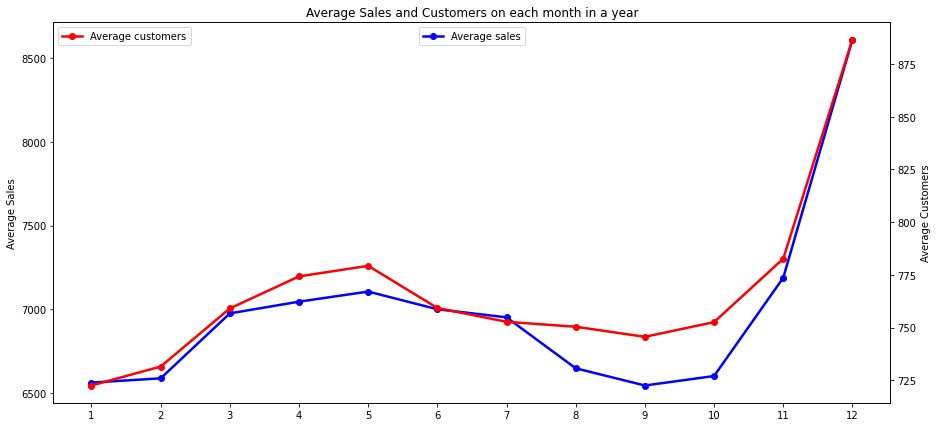

In [82]:
sales_per_days = tmp.groupby("Month")["Sales"].mean()
customers_per_days = tmp.groupby("Month")["Customers"].mean()

fig, ax1 = plt.subplots(figsize=(15,7))
ax1.plot(sales_per_days, "bo-", label="Average sales", linewidth=2.5)
xticks = [i for i in range(13)]
plt.setp(ax1, xticks=xticks)
ax1.set_ylabel("Average Sales")
ax2 = ax1.twinx()
ax2.plot(customers_per_days, "ro-", label = "Average customers", linewidth=2.5)
ax2.set_ylabel("Average Customers")
ax2.legend()
ax1.legend(loc="upper center")
plt.title("Average Sales and Customers on each month in a year")
plt.show()

Saturday has the lowest sales across the week while at the end of the ear, or I think in the winter, people buy more drugs and medicines.

In [83]:
del customer_df, tmp, sales_per_days, customers_per_days, xticks

## **Section 8: Train Test Split and Modelling (Q8)**

### Preprocessing

First, scan for NaN and Null. Looks like that only store.csv contains NaN value.

In [39]:
store_df.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [40]:
# We have three NaN in CompetitionDistance. Check if those stores have competitors or not
store_df[store_df["CompetitionDistance"].isnull()]

# => These stores didn't have any competitor. 

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [41]:
# Im gonna drop PromoInterval
store_df = store_df.drop(["PromoInterval"], axis=1)

In [42]:
store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].median(), inplace=True)
store_df["CompetitionOpenSinceMonth"].fillna(store_df["CompetitionOpenSinceMonth"].median(), inplace=True)
store_df["CompetitionOpenSinceYear"].fillna(store_df["CompetitionOpenSinceYear"].median(), inplace=True)
store_df["Promo2SinceWeek"].fillna(store_df["Promo2SinceWeek"].median(), inplace=True)
store_df["Promo2SinceYear"].fillna(store_df["Promo2SinceYear"].median(), inplace=True)

Then, we need to transform categorical features into binary features (one hot). This step can be done on both train and test set because we already knew what StateHoliday, StoreType, and Assortment look like (from Kaggle competition description).

In [43]:
store_df = pd.concat([store_df, pd.get_dummies(store_df["StoreType"], prefix="StoreType")], axis=1)
store_df = pd.concat([store_df, pd.get_dummies(store_df["Assortment"], prefix="Assortment")], axis=1)

In [44]:
store_df = store_df.drop(["StoreType", "Assortment"], axis=1)

In [45]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [46]:
train_df = pd.concat([train_df, pd.get_dummies(train_df["StateHoliday"], prefix="StateHoliday")], axis=1)

In [47]:
train_df["Day"] = train_df["Date"].apply(lambda x: x.day)
train_df["Month"] = train_df["Date"].apply(lambda x: x.month)
train_df["Year"] = train_df["Date"].apply(lambda x: x.year)

In [48]:
train_df = train_df.drop(["Date", "StateHoliday"], axis=1)

In [49]:
# Merge again
data = pd.merge(train_df, store_df, how="inner", on=["Store", "Store"], left_index=True)

### Train/Validation Set Split

In [21]:
months = [5, 6, 7]
validation = data.loc[(data["Month"].isin(months)) & (data["Year"]==2015)]
val_label = validation["Sales"].to_numpy()
validation = validation.drop(["Sales"], axis=1)
val_set = validation.to_numpy()

In [22]:
train = data.loc[~((data["Month"].isin(months)) & (data["Year"]==2015))]
train = train.loc[train["Open"] != 0]
train_label = train["Sales"].to_numpy()
train = train.drop(["Sales"], axis=1)
train_set = train.to_numpy()

### RMSPE

In [23]:
def rmspe(y_true, y_pred):
    mask = y_true != 0
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    return (np.mean(((y_true - y_pred)/y_pred)**2))**0.5

### Model: Random Forest Regressor

In [60]:
from sklearn.ensemble import RandomForestRegressor
import time

In [25]:
RF_models = [RandomForestRegressor(n_estimators=20),
             RandomForestRegressor(n_estimators=50),
             RandomForestRegressor(n_estimators=70),
             ]

In [26]:
for i, model in enumerate(RF_models):
    start = time.time()
    model.fit(train_set, train_label)
    end = time.time()
    y_pred = model.predict(val_set)
    print("RMSPE Model{}:".format(i), rmspe(val_label, y_pred), "Training time:", end - start)

RMSPE Model0: 0.07487018589332814 Training time: 99.96444296836853
RMSPE Model1: 0.07378772591763642 Training time: 247.27238583564758
RMSPE Model2: 0.07341370157844476 Training time: 339.45834851264954


### Model: XGBoost Regressor

In [37]:
import xgboost as xgb

In [28]:
XGB_models = [xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators=1000, verbosity = 0),
              xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators=2000, verbosity = 0),
              xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators=5000, verbosity = 0)
              ]

In [29]:
for i, model in enumerate(XGB_models):
    start = time.time()
    model.fit(train_set, train_label)
    end = time.time()
    y_pred = model.predict(val_set)
    print("RMSPE Model{}:".format(i), rmspe(val_label, y_pred), "Training time:", end - start)

RMSPE Model0: 0.09560906073788249 Training time: 37.51187252998352
RMSPE Model1: 0.08180970962812217 Training time: 72.58781242370605
RMSPE Model2: 0.07138288881169128 Training time: 181.42670464515686


## **Section 9: t-test (Q9)**

In [45]:
best_RF = RF_models[-1].predict(val_set)
best_XGB = XGB_models[-1].predict(val_set)
mean_1 = best_RF.mean()
var_1 = best_RF.var()
n1 = len(best_RF)
mean_2 = best_XGB.mean()
var_2 = best_XGB.var()
n2 = len(best_XGB)

In [46]:
denominator = var_1**2/n1 + var_2**2/n2
t_test = (mean_1 - mean_2)/np.sqrt(denominator)
print("Welch t-test score:", t_test)

Welch t-test score: -0.007743375993011523


Note: I checked with other sources about Welch's t-test and I think s is standard deviation rather than variance in professor lecture. Using std I got the same result as using Scipy below.

In [47]:
var_1 = best_RF.std()
var_2 = best_XGB.std()

denominator = var_1**2/n1 + var_2**2/n2
t_test = (mean_1 - mean_2)/np.sqrt(denominator)
print("Welch t-test score:", t_test)

Welch t-test score: -28.00089030059179


In [44]:
from scipy import stats
# Compare with Scipy package

stats.ttest_ind(best_RF, best_XGB)

Ttest_indResult(statistic=-28.000753962729647, pvalue=3.364627938221781e-172)

**Conclusion**: With p-value ~ 0, we reject the null hypothesis that mean_1 and mean_2 are equal. So actually, it has the significant enough different mean.

In [61]:
del best_RF, best_XGB

## **Section 10: Screenshots (Q10)** 

In [50]:
train_label = data["Sales"].to_numpy()
train_data = data.drop(["Sales"], axis=1).to_numpy()

In [52]:
test = pd.read_csv("test.csv", parse_dates=["Date"])
test = pd.merge(test, store_df, how="inner", on=["Store", "Store"], left_index=True)
test = pd.concat([test, pd.get_dummies(test["StateHoliday"], prefix="StateHoliday")], axis=1)
test["StateHoliday_b"] = np.zeros((41088,))
test["StateHoliday_c"] = np.zeros((41088,))
test["StateHoliday_d"] = np.zeros((41088,))

In [55]:
test.fillna(1, inplace=True)
test.isnull().sum()

Id                           0
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
StoreType_a                  0
StoreType_b                  0
StoreType_c                  0
StoreType_d                  0
Assortment_a                 0
Assortment_b                 0
Assortment_c                 0
StateHoliday_0               0
StateHoliday_a               0
StateHoliday_b               0
StateHoliday_c               0
StateHoliday_d               0
dtype: int64

In [56]:
test["Day"] = test["Date"].apply(lambda x: x.day)
test["Month"] = test["Date"].apply(lambda x: x.month)
test["Year"] = test["Date"].apply(lambda x: x.year)
test = test.drop(["Date", "StateHoliday"], axis=1)
columns = data.drop(["Sales", "Customers"], axis=1).columns

In [57]:
test_df = test.drop(["Id"], axis=1)[columns]
test_data = test_df.to_numpy()

In [58]:
train_label = data["Sales"].to_numpy()
train_data = data.drop(["Sales", "Customers"], axis=1).to_numpy()

In [62]:
# RF Model
rf_model = RandomForestRegressor(n_estimators=70)
# XGB Model
xgb_model = xgb.XGBRegressor(tree_method = 'gpu_hist', n_estimators=5000, verbosity = 0)

In [63]:
rf_model.fit(train_data, train_label)
y_pred = rf_model.predict(test_data)
test["Sales"] = y_pred
test[["Id", "Sales"]].to_csv("rf.csv", index=False)

In [64]:
xgb_model.fit(train_data, train_label)
y_pred = xgb_model.predict(test_data)
test["Sales"] = y_pred
test[["Id", "Sales"]].to_csv("xgb.csv", index=False)

In [68]:
from google.colab import files
files.download('rf.csv')
files.download('xgb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Public Score & Highest Rank: 0.12927

Private Score & Highest Rank: 0.15220

Kaggle profile link: https://www.kaggle.com/anhnguyen113094662

Screenshot(s): 
![picture](https://drive.google.com/uc?export=view&id=1kC2-O7UCSIk7tRm_xHLD-W0twJ5Z8Q9t)